In [20]:
import sys
sys.path.append('../')
sys.path.append("../src/")

import time
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from pytorch.model import UNet
from pytorch.looper import Looper
import pytorch.utils as torch_utils
from pytorch.utils import SegmentationDataset, AugmentorSegmentationDataset
from torchvision import transforms

def display_img(img):
    fig, ax = plt.subplots(figsize=(10, 20))
    plt.imshow(img, cmap="gray")

In [21]:
# --- PYTESTS --- # to check UNet network output
from pytorch.model import test_UNet_color, test_UNet_grayscale

test_UNet_color()
test_UNet_grayscale()

In [8]:
dataset_caps_color = ["black", "green", "greenblurry"]
data_aug = False

if data_aug == True:
    transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ColorJitter( brightness=0.5*np.random.rand(),
                                    contrast=0.5*np.random.rand(),
                                    #    saturation=0.1*np.random.rand(),
                                    #    hue=0.1*np.random.rand()
                                    ),
            transforms.PILToTensor()
        ])
else:
    transform = None

network_architecture = "UNet"
dataset_name = ""
for subdataset in dataset_caps_color:
    dataset_name = dataset_name + "_" + subdataset
if data_aug == True:
    dataset_name = dataset_name + "_augmented"

ds = SegmentationDataset("../dataset/training/", transform=transform)
print(dataset_name)

_black_green_greenblurry


In [9]:
lengths = ((int(len(ds)*0.8), int(len(ds)*0.2)) if len(ds)%2 != 0 else (int(len(ds)*0.8) + 1, int(len(ds)*0.2)))
print(lengths)
train, val = torch.utils.data.random_split(ds, lengths)

(356, 89)


In [10]:
train_loader = DataLoader(train, batch_size=8,shuffle=True, num_workers=0)
valid_loader = DataLoader(val, batch_size=8,shuffle=True, num_workers=0)

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model = UNet(input_filters=1, filters=64, N=2).to(device)
model = torch.nn.DataParallel(model)

cpu


In [12]:
# initialize loss, optimized and learning rate scheduler
loss = torch.nn.BCELoss() # Measures the  Binary Cross Entropy between the target and the input probabilities
optimizer = torch.optim.Adam(model.parameters())
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# create training and validation Loopers to handle a single epoch
train_looper = Looper(model, device, loss, optimizer,
                      train_loader, len(train))
valid_looper = Looper(model, device, loss, optimizer,
                      valid_loader, len(val), validation=True )

In [ ]:
# current best results (lowest mean absolute error on validation set)
current_best = np.infty
num_epochs = 10
for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}\n")

        # run training epoch and update learning rate
        train_looper.run()
        lr_scheduler.step()

        # run validation epoch
        with torch.no_grad():
            result = valid_looper.run()
            
        # update checkpoint if new best is reached
        if result < current_best:
            current_best = result
            model_name = f'../trained_models/new_trained_models/model{dataset_name}_{network_architecture}_best.pth'
            torch.save(model.state_dict(), model_name)
            print(f"\nNew best result: {result}")
        print("\n", "-"*80, "\n", sep='')

print(f"[Training done] Best result: {current_best}")
torch.save(model.state_dict(), f'../trained_models/new_trained_models/model{dataset_name}_{network_architecture}_{time.time()}.pth')

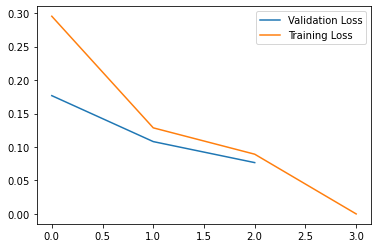

In [14]:
plt.plot(valid_looper.running_loss, label='Validation Loss')
plt.plot(train_looper.running_loss, label='Training Loss')
plt.legend()